In [1]:
import sys

sys.path.insert(0, '..')

import torch
import numpy as np
import torchvision
from torchvision import transforms

from dataset.dataloader import TorchLoader
from net.intermediate import IntermediateNetwork
from net.ssd import SSD300, MultiBoxLoss
from utils.obj_utils import cxcy_to_xy, cxcy_to_gcxgcy, xy_to_cxcy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [2]:
coco_root = '/home/sixigma/workplace/meow/coco_data/'
coco = torchvision.datasets.coco.CocoDetection(root=coco_root + 'train/train2017/', annFile=coco_root + 'annotations/instances_train2017.json')

loading annotations into memory...
Done (t=9.65s)
creating index...
index created!


In [3]:
resnet = IntermediateNetwork('resnet50', [5, 6]).to(device)
ssd_net = SSD300(resnet, 90 + 1).to(device)

In [4]:
start_lr = 0.1
momentum = 0.9
weight_decay = 5e-4
optimizer = torch.optim.SGD(ssd_net.parameters(), lr=start_lr, momentum=momentum, weight_decay=weight_decay)
priors = ssd_net.priors_cxcy.to(device)
criterion = MultiBoxLoss(priors_cxcy=priors)

/home/sixigma/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [5]:
coco_transform = transforms.Compose([transforms.Resize((300, 300)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
batch_size = 8
images = []

In [6]:
def collate_fn_coco(batch):
    images, annos = tuple(zip(*batch))
    t_images = torch.empty((0, 3, 300, 300))
    b_bboxes = []
    b_labels = []
    for i, image in enumerate(images):
        labels = []
        bboxes = []
        r_width = 1 / image.size[0]
        r_height = 1 / image.size[1]
        t_image = torch.unsqueeze(coco_transform(image), dim=0)
        t_images = torch.cat((t_images, t_image))
        for anno in annos[i]:
            bbox = [anno['bbox'][0] * r_width, anno['bbox'][1] * r_height, 
                    (anno['bbox'][0] + anno['bbox'][2]) * r_width, (anno['bbox'][1] + anno['bbox'][3]) * r_height]
            bboxes.append(bbox)
            labels.append(anno['category_id'])
        b_bboxes.append(torch.tensor(bboxes))
        b_labels.append(torch.tensor(labels))
        
    return t_images, b_bboxes, b_labels

In [7]:
sampler = torch.utils.data.RandomSampler(coco)
batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last=True)
 
data_loader = torch.utils.data.DataLoader(
        coco, batch_sampler=batch_sampler, num_workers=4,
        collate_fn=collate_fn_coco)

In [11]:
losses = []
for i, (imgs, b_bboxes, b_labels) in enumerate(data_loader):
    pred_locs, pred_cls_prob = ssd_net(imgs.to(device))

    for b in range(len(b_bboxes)):
        b_bboxes[b] = b_bboxes[b].to(device)
        b_labels[b] = b_labels[b].to(device)

    loss = criterion(pred_locs.to(device), pred_cls_prob.to(device), b_bboxes, b_labels)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    if i % 1000 == 0:
        losses.append(loss)
    
    if i == 13000:
        break

In [12]:
losses

[tensor(94.5946, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(229.9154, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(87.2741, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(54.5901, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(126.6170, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(179.0479, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(194.2530, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(196.3931, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(146.2837, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(162.0007, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(139.6081, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(341.2047, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(212.0290, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(152.1187, device='cuda:0', grad_fn=<AddBackward0>)]

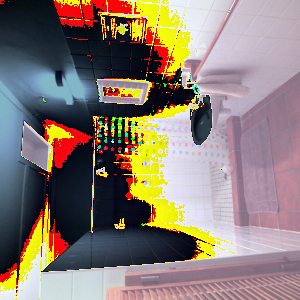

In [45]:
from PIL import Image
import numpy as np
img = imgs[1].permute(2, 1, 0)

Image.fromarray(np.array(img.numpy() * 17 / [0.25, 0.224, 0.225] + [0.485, 0.456, 0.406], dtype=np.uint8))